# Import Libraries

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

### Ignore Warnings

In [2]:
warnings.filterwarnings('ignore')

# Import Data

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

# Preprocessing Data

## Create "FamilyMem" feature

In [4]:
train_df["FamilyMem"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilyMem"] = test_df["SibSp"] + test_df["Parch"] + 1

## Create "Age_group" feature

In [5]:
def create_age_groups(df):
  age_group = list()
  for age in df["Age"]:
    if (age <= 12):
      age_group.append("child")
    elif (age <= 18):
      age_group.append("teen")
    elif (age <= 30):
      age_group.append("young")
    elif (age <= 45):
      age_group.append("middle")
    else:
      age_group.append("old")
  df["Age_group"] = age_group
  return df

In [6]:
train_df = create_age_groups(train_df)
test_df = create_age_groups(test_df)

## Create "Family_size" feature

In [7]:
def create_family_size(df):
  family_size = list()
  for family in df["FamilyMem"]:
    if (family < 2):
      family_size.append("single")
    elif (family < 5):
      family_size.append("small")
    else:
      family_size.append("big")
  df["Family_size"] = family_size
  return df

In [8]:
train_df = create_family_size(train_df)
test_df = create_family_size(test_df)

## Create "Fare_Cat" feature

In [9]:
def cat_fare(df):
  fare_cate = list()
  for fare in df["Fare"]:
    if (fare < 20):
      fare_cate.append("Low")
    elif (fare <= 50):
      fare_cate.append("Medium")
    else:
      fare_cate.append("High")
  df["Fare_Cat"] = fare_cate
  return df

In [10]:
train_df = cat_fare(train_df)
test_df = cat_fare(test_df)

## Rerange "Deck" feature

In [11]:
def regroup_deck(deck):
    if deck in ["A", "B", "C", "T"]:
        return "ABC"
    elif deck in ["D", "E", "F"]:
        return "DEF"
    else:
        return deck

def impute_deck(data):
    if data["Deck"] is np.nan:
        if data["Pclass"] == 1:
            return "ABC"
        elif data["Pclass"] == 2:
            return "DEF"
        elif data["Pclass"] == 3:
            if data["Fare_Cat"] == "Low":
                return "G"
            else:
                return "DEF"
    else:
        return data["Deck"]

In [12]:
train_df["Deck"] = [np.nan if pd.isnull(cabin) else cabin[0] for cabin in train_df["Cabin"]]
test_df["Deck"] = [np.nan if pd.isnull(cabin) else cabin[0] for cabin in test_df["Cabin"]]

# reorganized Deck group
train_df["Deck"] = train_df["Deck"].apply(regroup_deck)
test_df["Deck"] = test_df["Deck"].apply(regroup_deck)

# filling missing Deck
train_df["Deck"] = train_df.apply(impute_deck, axis = 1)
test_df["Deck"] = test_df.apply(impute_deck, axis = 1)

## Create "Title" Feature

In [13]:
def find_title(name):
    return (name.split(", ")[1]).split(".")[0]

def extract_title(name):
    title = find_title(name)
    return title if title in "Mr Miss Mrs Master".split(" ") else "Others"

train_df["Title"] = train_df["Name"].apply(extract_title)
test_df["Title"] = test_df["Name"].apply(extract_title)

# Processing Data

In [14]:
X = train_df.copy()
X_test = test_df.copy()

## Missing Data

### Fill Age with mean by Pclass

In [15]:
drop_columns = ["PassengerId", "Name", "Ticket", "SibSp", "Parch", "Cabin"]
X = train_df.drop(drop_columns, axis = 1)
X_test = test_df.drop(drop_columns, axis = 1)

In [16]:
# Training dataset
train_age = list()
for row in train_df[["Pclass", "Age"]].values:
  if (np.isnan(row[1])):
    if (row[0] == 1):
      train_age.append(39)
    elif (row[0] == 2):
      train_age.append(30)
    else:
      train_age.append(25)
  else:
    train_age.append(row[1])
X["Age"] = train_age

# Test dataset
test_age = list()
for row in test_df[["Pclass", "Age"]].values:
  if (np.isnan(row[1])):
    if (row[0] == 1):
      test_age.append(39)
    elif (row[0] == 2):
      test_age.append(30)
    else:
      test_age.append(25)
  else:
    test_age.append(row[1])
X_test["Age"] = test_age

In [17]:
X_test["Fare"].fillna(X_test["Fare"].min(), inplace = True)
X["Embarked"].fillna("C", inplace = True)

## Encoding features

In [18]:
y = train_df["Survived"]
age_group = pd.get_dummies(X['Age_group'], drop_first=True)
age_group1 = pd.get_dummies(X_test['Age_group'], drop_first=True)

family_size = pd.get_dummies(X['Family_size'], drop_first=True)
family_size1 = pd.get_dummies(X_test['Family_size'], drop_first=True)

deck = pd.get_dummies(X['Deck'], drop_first=True)
deck1 = pd.get_dummies(X_test['Deck'], drop_first=True)

cat_fare = pd.get_dummies(X['Fare_Cat'], drop_first=True)
cat_fare1 = pd.get_dummies(X_test['Fare_Cat'], drop_first=True)

sex = pd.get_dummies(X['Sex'], drop_first=True)
sex1 = pd.get_dummies(X_test['Sex'], drop_first=True)

embarked = pd.get_dummies(X['Embarked'], drop_first=True)
embarked1 = pd.get_dummies(X_test['Embarked'], drop_first=True)

pclass = pd.get_dummies(X['Pclass'],drop_first=True)
pclass1 = pd.get_dummies(X_test['Pclass'], drop_first=True)

title = pd.get_dummies(X['Title'],drop_first=True)
title1 = pd.get_dummies(X_test['Title'],drop_first=True)

X = pd.concat([X, title, deck, age_group, family_size, cat_fare, sex, embarked, pclass], axis=1)
X_test = pd.concat([X_test, title1, deck1, age_group1, family_size1, cat_fare1, sex1, embarked1, pclass1], axis=1)

## Drop columns and covert type

In [19]:
y = X["Survived"]
X.drop(["Pclass", "Sex", "Embarked", "Survived", "Family_size", "Fare_Cat", "Age_group", "Deck", "Title"], axis = 1, inplace = True)
X_test.drop(["Pclass", "Embarked", "Sex", "Family_size", "Fare_Cat", "Age_group", "Deck", "Title"], axis = 1, inplace = True)

In [20]:
X["Age"] = round(X["Age"]).astype("int")
X["Fare"] = round(X["Fare"]).astype("int")

X_test["Age"] = round(X_test["Age"]).astype("int")
X_test["Fare"] = round(X_test["Fare"]).astype("int")

In [21]:
print(X.head())
print(X_test.head())

   Age  Fare  FamilyMem   Miss     Mr    Mrs  Others    DEF      G  middle  \
0   22     7          2  False   True  False   False  False   True   False   
1   38    71          2  False  False   True   False  False  False    True   
2   26     8          1   True  False  False   False  False   True   False   
3   35    53          2  False  False   True   False  False  False    True   
4   35     8          1  False   True  False   False  False   True    True   

   ...  young  single  small    Low  Medium   male      Q      S      2      3  
0  ...   True   False   True   True   False   True  False   True  False   True  
1  ...  False   False   True  False   False  False  False  False  False  False  
2  ...   True    True  False   True   False  False  False   True  False   True  
3  ...  False   False   True  False   False  False  False   True  False  False  
4  ...  False    True  False   True   False   True  False   True  False   True  

[5 rows x 22 columns]
   Age  Fare  FamilyMe

# Classification model

### Split training data

In [22]:
X = np.array(X.values)
X_test = np.array(X_test.values)

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

## Random Forest Model

In [24]:
#random.seed(10)
rfc = RandomForestClassifier(random_state = 42)

In [25]:
param_grid = {
    'n_estimators': [100, 120],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6, 7, 8, 9, 10, 15],
    'criterion' :['gini', 'entropy']
}

In [26]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= StratifiedKFold(n_splits = 5))
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8, 9, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 120]})

In [27]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 120}
0.8371417315079286


0.8100558659217877


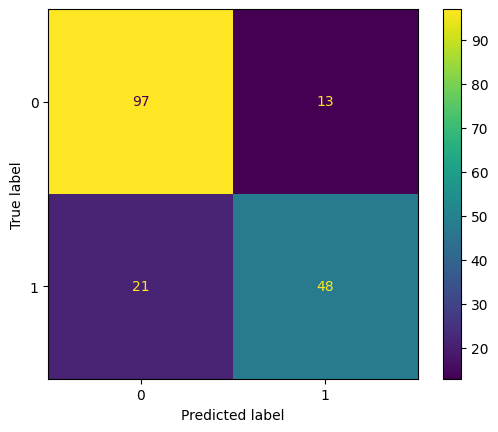

In [28]:
clf = CV_rfc.best_estimator_
predictions = clf.predict(X_valid)
print(accuracy_score(y_valid, predictions))
cfs_mtx = confusion_matrix(y_valid, predictions)
disp = ConfusionMatrixDisplay(cfs_mtx)
disp.plot()

# Make submission

In [29]:
clf = RandomForestClassifier(random_state = 42, criterion = 'entropy', max_features = 'auto', max_depth = 6, n_estimators = 120)
clf.fit(X, y)
predictions = clf.predict(X_test)
print("Number of records: ", len(predictions))
submission = pd.DataFrame()
submission["PassengerId"] = test_df["PassengerId"]
submission["Survived"] = predictions
submission.set_index("PassengerId", inplace = True)
submission.to_csv(path_or_buf = '/kaggle/working/rf_submission.csv')

Number of records:  418
